In [9]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install wordcloud
!pip install sklearn


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
  Using cached matplotlib-3.5.2-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.3 MB)
  Using cached fonttools-4.34.4-py3-none-any.whl (944 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached Pillow-9.2.0-cp38-cp38-manylinux_2_28_x86_64.whl (3.2 MB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 10.1 MB/s eta 0:00:00
  Using cached scipy-1.8.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.6 MB)

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 34.4 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [38]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
from text_preprocessing import clean_stopwords 

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../models/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [16]:
# Esto se hace si no se puede importar el archivo
def clean_stopwords(text: str,stop_dict: dict)->str:
    if text is not None:
        words = text.split()
        words_clean = []
        for word in words:
            if word not in stop_dict:
                words_clean.append(word)
        result = ' '.join(words_clean)
    else:
        result = None
    return result

In [12]:
nrc

,word,sentiment,polarity
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141461,zest,anticipation,1
141464,zest,joy,1
141466,zest,positive,1
141469,zest,trust,1


In [13]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../models/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [14]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
743,Twitter Web Client,100658594206322688,He's hired! Listen to my #Apprentice Andy laun...,2011-08-08T20:04:13Z,18,NaN,6,False
8072,Twitter Web Client,309692098217652224,"@a123r7o Thanks, good choice &amp; good luck.",2013-03-07T15:48:44Z,0,94402515.0,3,False
5261,Twitter Web Client,377187904792956928,"“It is hard to fail, but it is worse never to ...",2013-09-09T21:52:58Z,515,NaN,220,False
11885,Twitter Web Client,431186056130469888,Negotiation: It is persuasion more than power.,2014-02-05T22:02:21Z,270,NaN,267,False
20372,Twitter for iPhone,839968149890076672,'U.S. Consumer Comfort Just Reached Its Highes...,2017-03-09T22:36:27Z,16144,NaN,67344,False
12185,Twitter for iPhone,678982347392438272,Phyllis Schlafly: Trump is 'last hope for Amer...,2015-12-21T16:56:21Z,2492,NaN,5608,False
12780,Twitter for Android,659759194262798336,.@SpeakerRyan Congratulations and good luck - ...,2015-10-29T15:50:24Z,811,NaN,1932,False
8063,Twitter Web Client,310035899759087616,@SavvY_PriNceSS Thanks Becky.,2013-03-08T14:34:53Z,1,50901155.0,2,False
10780,Twitter Web Client,497770498374516738,"Sorry, I won’t be able to do @foxandfriends at...",2014-08-08T15:45:09Z,16,NaN,44,False
1837,Twitter Web Client,261901502430461953,Obama is about to destroy the mililtary throug...,2012-10-26T18:45:58Z,477,NaN,128,False


In [17]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [18]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [20]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [21]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [22]:
# 2.5 Consider time is UTC, convert to EST 

df_interim['created_at'] += pd.Timedelta(-5,unit='h')


In [23]:
# 2.5 Filter source for analysis - Nos quedamos con iphone y android
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [25]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [26]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [27]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
16304,Twitter for iPhone,"Thank you Portland, Maine! \n#MakeAmericaGreat...",2016-08-04 17:42:13,5438,18060
17931,Twitter for Android,"What a great night. Thank you South Carolina, ...",2016-02-20 22:01:10,5940,19522
17225,Twitter for iPhone,Trump locks down Delaware GOP delegates. #Trum...,2016-04-30 15:50:42,4384,11943
12971,Twitter for iPhone,My interview with @HowardKurtz on #MediaBuzz w...,2015-10-10 14:11:14,731,1461
17834,Twitter for Android,I will be on @foxandfriends at 8:30 A.M. Will ...,2016-02-27 08:08:21,1949,7458
12528,Twitter for Android,13 Syrian refugees were caught trying to get i...,2015-11-22 10:53:38,5602,12230
15564,Twitter for iPhone,.@HillaryClinton talking about jobs? Remember ...,2016-10-19 20:39:40,6933,12369
17197,Twitter for iPhone,MAKE AMERICA GREAT AGAIN!\n#INPrimary #VoteTru...,2016-05-03 13:29:03,5101,13064
15846,Twitter for iPhone,An honor to meet with the Polish American Cong...,2016-09-28 12:40:10,7224,18333
18151,Twitter for Android,It all begins today - WE WILL FINALLY TAKE OUR...,2016-02-01 08:25:20,9112,21635


In [28]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 07:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 20:03:05,61.000000,167.000000
25%,2015-12-20 18:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 05:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 09:04:26.500000,7807.250000,21527.000000
max,2016-11-07 17:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [29]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

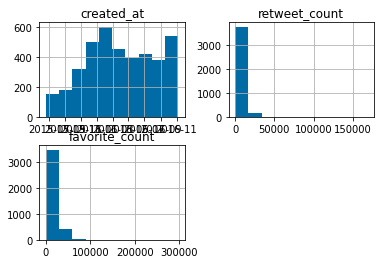

In [30]:
# 3.5 Get histograms for numerical data

df.hist()
plt.show()

In [31]:
# 3.6 Make a plot of tweets frequence rate by source
df_plot = (df
           .assign(hour=df['created_at'].dt.hour)
           .groupby(['source','hour'])
           .agg(count=('source','count'))
           .assign(rate=lambda df: df['count']/df.groupby('source')['count'].sum())
           .reset_index())
df_plot           


,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


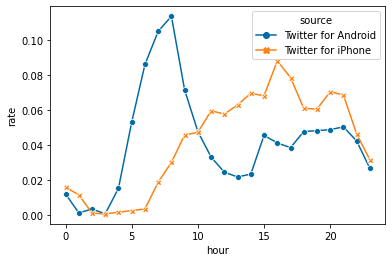

In [32]:
sns.lineplot(data=df_plot,x='hour',y='rate',hue='source',markers=True,style='source',dashes=False)
plt.show()

In [33]:
# 3.7 Get a glimpse of the most retweeted tweets
df.sort_values(by='retweet_count',ascending=False)[['text','retweet_count']][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [34]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='favorite_count',ascending=False)[['text','favorite_count']][:10]

,text,favorite_count
16875,How long did it take your staff of 823 people ...,297281
16548,Such a great honor to be the Republican Nomine...,129652
15758,Here is my statement. https://t.co/WAZiGoQqMQ,120244
15781,Mike Pence won big. We should all be proud of ...,120189
17183,Happy #CincoDeMayo! The best taco bowls are ma...,119759
15333,MAKE AMERICA GREAT AGAIN!,115387
15827,For those few people knocking me for tweeting ...,107497
15756,The media and establishment want me out of the...,105680
15340,If Obama worked as hard on straightening out o...,102045
16583,I am pleased to announce that I have chosen Go...,92250


In [35]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [39]:
# 3.10 Process text to extract stopwords
df['text_clean']=df.text.str.lower()
stop_dict = stopwords.words('english')
df['text_clean']=df['text_clean'].apply(lambda x: clean_stopwords(x,stop_dict=stop_dict))
df['text_clean']=df['text_clean'].str.replace(r'''['!,.]''','',regex=True)

In [40]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df['text_clean']=df['text_clean'].str.replace(url_pat,'',regex=True)


In [41]:
# 3.12 Extract special characters

df['text_clean']=df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''','',regex=True)




In [42]:
# 3.13 Extract numbers

df['text_clean']=df['text_clean'].str.replace(r'[\d]+','',regex=True)


In [43]:
# 3.14 See the results
df[['text','text_clean']].sample(10)

,text,text_clean
16181,#LawandOrder #ImWithYou\nVideo: https://t.co/A...,#lawandorder #imwithyou video httpstcoaiazpoh ...
15867,'How Trump won over a bar full of undecideds a...,how trump bar full undecideds democrats httpst...
12633,Thank you @JakeTapper for giving me credit for...,thank @jaketapper giving credit vision bombing...
18458,Man shot inside Paris police station. Just ann...,man shot inside paris police station announced...
16567,I hope that Crooked Hillary picks Goofy Elizab...,hope crooked hillary picks goofy elizabeth war...
18478,"Iran, with all of the money and all else given...",iran money else given obama wanted way take sa...
16000,Will be in Missouri today with Melania for the...,missouri today melania funeral wonderful truly...
15791,.@mike_pence and I will defeat #ISIS.\nhttps:/...,@mike_pence defeat #isis httpstcoociidwtptv #v...
15617,I will Make Our Government Honest Again -- bel...,make government honest believe me first im go...
17994,Jeb used Eminent Domain &amp; took advantage o...,jeb used eminent domain took advantage disabl...


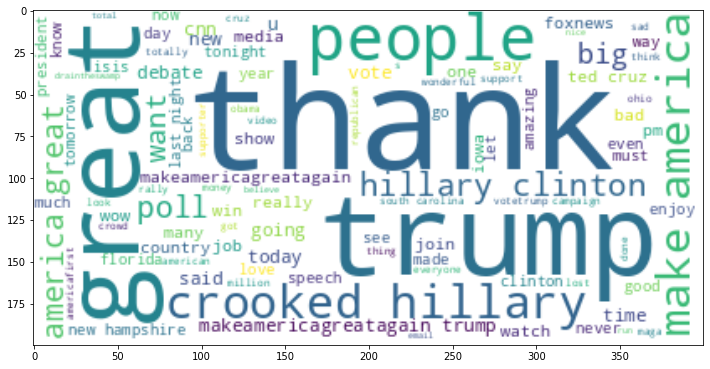

In [45]:
# 3.15 Let's see a wordcloud
text = ' '.join(i for i in df.text_clean)
wordcloud = WordCloud(max_words=100,background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()


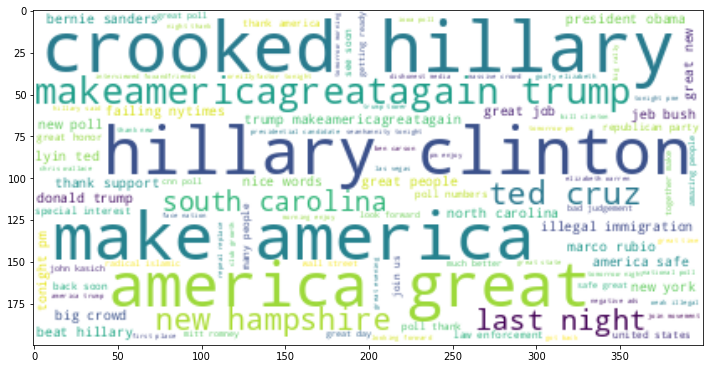

In [46]:
# Dos palabras que se repiten una y otra vez - Bigramo - dos palabras que van juntas
# y ver cuantas veces se repiten

wordcloud_bg = WordCloud(collocation_threshold=2,collocations=True,max_words=100,background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud_bg,interpolation='bilinear')
plt.show()



In [47]:
# Trocear el texto, asociar las palabras con los sentimientos

df_word_split = (df
                 .drop(['text','created_at','retweet_count','favorite_count'],axis=1)
                 .assign(text=df['text_clean'].str.split())).explode('text').drop('text_clean',axis=1).rename(columns={'text':'word'})
df_word_split                 

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [48]:
# aplicamos un join
df_word_split.merge(nrc[['word','sentiment']],on='word',how='inner')

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [49]:
df_sent = df_word_split.\
    merge(nrc[['word','sentiment']],on='word',how='inner').\
    groupby(['source','sentiment']).agg(count=('sentiment','count')).\
    reset_index().pivot_table(index=['sentiment'],columns=['source'],values='count').\
    reset_index().\
    rename(columns={"Twitter for Android":"Android","Twitter for iPhone":"iPhone"})  

df_sent                  

source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [50]:
# frecuencias relativas 
# odd ratio
# Vamos a calcular un intervalo de confianza 

df_odd_ratio = df_sent.\
               assign(odd_ratio=(df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone'].sum()-df_sent['iPhone'])))

df_odd_ratio['log_or']=np.log(df_odd_ratio['odd_ratio'])


In [52]:
df_odd_ratio.sort_values(by='log_or',ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


In [ ]:
# Vamos a crear intervalos de confianza

# error standard
df_odd_ratio['se']=np.sqrp
